# 实际数据导入

In [2]:
import pandas as pd
import numpy as np
import casadi as cs
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import sym_metanet as metanet
from sym_metanet import (
    Destination,
    Link,
    LinkWithAccident,
    MainstreamOrigin,
    MeteredOnRamp,
    Network,
    Node,
    engines,
)
from scipy.optimize import minimize

#time input
start_point = 6*12
end_point = 22*12
#事故时间点
accident_point = 17*12-start_point #下午5：00左右(又人工前移五个点)
accident_finish = 223-start_point #持续约1.5h
#file input
flow = pd.read_csv("../../event_model_flow.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
speed = pd.read_csv("../../event_model_speed.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
off_ramp_rate = pd.read_csv("../../event_model_down.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
on_ramp = pd.read_csv("../../event_model_up.csv",index_col=0,parse_dates=True).iloc[start_point:end_point]
#time parameters input
measure_time = 300
simulation_time = 5
sampling_interval = int(measure_time / simulation_time)
T = simulation_time/3600
#global parameters input
tau = 18 / 3600
kappa = 40
eta = 60
delta = 0.0122
phi = 0.02
#local parameter input(以下参数均可考虑异质性)
C = 2000 #匝道通行能力
a = 1.867
rho_crit = 33.5
rho_max = 180
v_free = 102

# 构建路网及其动态

In [3]:
lanes = [4,4,4,4,4]
link_lengths = [1.15,0.30,5.41,1.24,0.68]
num_segments = [5,1,27,6,3]
segment_lengths = [round(i,3) for i in list(np.array(link_lengths)/np.array(num_segments))]
N1 = Node(name="N1")
N2 = Node(name="N2")
N3 = Node(name="N3")
N4 = Node(name="N4")
N5 = Node(name="N5")
N6 = Node(name="N6")
N_off1 = Node(name="N_off1")
N_off2 = Node(name="N_off2")


O1 = MainstreamOrigin[cs.SX](name="O1")
O_GL = MeteredOnRamp[cs.SX](C, name="O_GL")
O_JC = MeteredOnRamp[cs.SX](C, name="O_JC")

D1 = Destination[cs.SX](name="D1")
D_GL = Destination[cs.SX](name="D_GL")
D_JC = Destination[cs.SX](name="D_JC")

L1 = Link[cs.SX](num_segments[0], lanes[0], segment_lengths[0], rho_max, rho_crit, v_free, a, name="L1")
L2 = Link[cs.SX](num_segments[1], lanes[1], segment_lengths[1], rho_max, rho_crit, v_free, a, name="L2")
L3 = Link[cs.SX](num_segments[2], lanes[2], segment_lengths[2], rho_max, rho_crit, v_free, a, name="L3")
L4 = Link[cs.SX](num_segments[3], lanes[3], segment_lengths[3], rho_max, rho_crit, v_free, a, name="L4")
L5 = LinkWithAccident[cs.SX](num_segments[4], lanes[4], segment_lengths[4], rho_max, rho_crit, v_free, a, 
                            segment_with_acci=2, lane_drop=2, accident_start_time=accident_point*sampling_interval, accident_end_time=accident_finish*sampling_interval,
                            name="L5")
L_off1 = Link[cs.SX](1, 2, 0.2, rho_max, rho_crit, v_free, a, name="L_off1") #1段两百米的下匝道（2车道）
L_off2 = Link[cs.SX](1, 2, 0.2, rho_max, rho_crit, v_free, a, name="L_off2")

net = (
    Network(name="A1")
    .add_path(origin=O1, path=(N1, L1, N2, L2, N3, L3, N4, L4, N5, L5, N6), destination=D1)
    .add_path(path=(N1, L1, N2,L_off1,N_off1), destination=D_GL)
    .add_path(path=(N1, L1, N2, L2, N3, L3, N4,L_off2,N_off2), destination=D_JC)
    .add_origin(O_GL, N3)
    .add_origin(O_JC, N5)
)
engines.use("casadi", sym_type="SX")

net.is_valid(raises=True)
net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta)
F = metanet.engine.to_function(
    net=net,
    more_out=True,
    compact=1,
    T=T,
)

# 根据实际数据，将demands和turn_rates升采样

In [4]:
#升采样函数
def upsample_interpolation(array_before_sampled=None, measure_time=measure_time, simulation_time=simulation_time, method_use='linear'):
    if array_before_sampled.ndim == 1:
        array_before_sampled = array_before_sampled.reshape(-1,1)
    if method_use == 'linear':
        time_index = pd.date_range(start='2024-01-01', periods=array_before_sampled.shape[0], freq=f'{measure_time}s')

        # 创建 DataFrame
        df = pd.DataFrame(array_before_sampled, index=time_index, columns=[f'col_{i}' for i in range(1, 1+array_before_sampled.shape[1])])

        # 升采样到3秒，并进行线性插值
        upsampled_df = df.resample('3s').mean().interpolate(method='linear')

        # 为了确保最终的时间范围正确，重新定义时间索引
        new_time_index = pd.date_range(start=df.index[0], end=df.index[-1] + pd.Timedelta(seconds=300), freq=f'{simulation_time}s')
        upsampled_df = upsampled_df.reindex(new_time_index)
        upsampled_df = upsampled_df.resample(f'{simulation_time}s').mean().interpolate(method='linear')
        upsampled_df = upsampled_df.iloc[:-1,:]
        upsampled_array = upsampled_df.values
        return upsampled_array
    elif method_use == 'repeat':
        upsampled_array = np.repeat(array_before_sampled, repeats=int(measure_time/simulation_time), axis=0)
        return upsampled_array
#disturbance,创建demand及link的turnrate
demands = pd.concat([flow.iloc[:,0],on_ramp],axis=1).values
up_sampled_demands = upsample_interpolation(demands,method_use='linear')

all_link = list(net.links_by_name.values()) #"All links existing in the network"
link_to_change = [] # "The link that needs to have its turn rate revised."
for nnl in net.links:
    temp_link = nnl[-1]
    node_up,node_down = net.nodes_by_link[temp_link]
    if len(net.out_links(node_down)) > 1:
        link_to_change.extend([i[-1] for i in net.out_links(node_down)])
link_to_change_index = [all_link.index(i) for i in link_to_change] # The index of the link to be revised

turn_rates = np.ones((off_ramp_rate.shape[0],len(net.links)))
for i in range(len(off_ramp_rate.columns)):
    turn_rates[:,link_to_change_index[2*i]] = 1-off_ramp_rate.iloc[:,i]
    turn_rates[:,link_to_change_index[2*i+1]] = off_ramp_rate.iloc[:,i]
up_sampled_turn_rates = upsample_interpolation(turn_rates,method_use='linear')

# 运行模型

In [ ]:
#初始状态
from tqdm import tqdm
rho = cs.DM([5 for i in range(sum([i.N for i in net.links_by_name.values()]))])
v = cs.DM([100 for i in range(sum([i.N for i in net.links_by_name.values()]))])
w = cs.DM([0, 0, 0])
#控制措施(暂为无控)
v_ctrl = cs.DM.inf(1, 1)  # control speed at O1
r = cs.DM.ones(1, 1)  # ramp metering rates at O2
RHO, V, W, Q, Q_o = [], [], [], [], []
for index,d in tqdm(enumerate(up_sampled_demands)):
    rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r, up_sampled_turn_rates[index], index, d)
    RHO.append(rho)
    V.append(v)
    W.append(w)
    Q.append(q)
    Q_o.append(q_o)
RHO, V, W, Q, Q_o = (np.squeeze(o) for o in (RHO, V, W, Q, Q_o))

11520it [00:00, 11716.96it/s]


# 嵌入优化框架

### 实际的对比对象

In [ ]:
#创建用于对比的对象，pos_flow_array和pos_speed_array(供优化器构建损失函数)
flow_array = flow.values
speed_array = speed.values
non_negative_cols_flow = np.any(flow_array != -1, axis=0)
non_negative_cols_speed = np.any(speed_array != -1, axis=0)
pos_flow_array = flow_array[:,non_negative_cols_flow]
pos_speed_array = speed_array[:,non_negative_cols_speed]

### 仿真的对比对象

In [ ]:
net_num_segments = [5,1,1,27,6,1,3]
counter = 0
link_segment_dict = {}
for index,i in enumerate(net.links_by_name.keys()):
    link_segment_dict[i] = []
    for j in range(net_num_segments[index]):
        link_segment_dict[i].append(counter)
        counter+=1

off_links = ['L_off1','L_off2']
off_segments = []
for i in off_links:
    off_segments.extend(link_segment_dict[i])

In [ ]:
t_simulation = simulation_time  # 仿真步长（单位：秒）
t_measure = measure_time    # 测量时长（单位：秒）
    # 计算采样间隔
sampling_interval = int(t_measure / t_simulation)  # 采样间隔

60

In [ ]:
def loss_function(Q_sim, V_sim, Q_real, V_real):
    return 0.01*np.sqrt(np.mean((Q_sim - Q_real) ** 2)) + np.sqrt(np.mean((V_sim - V_real) ** 2))
# def loss_function(Q_sim, V_sim, Q_real, V_real):
#     return np.mean(abs(Q_sim - Q_real)/Q_real) + np.mean(abs(V_sim - V_real)/V_real)
# 假设你有真实的流量和速度数据
Q_real = pos_flow_array
V_real = pos_speed_array
# 定义一个优化目标函数
def objective(params):
    t_simulation = simulation_time  # 仿真步长（单位：秒）
    t_measure = measure_time    # 测量时长（单位：秒）
    # 计算采样间隔
    sampling_interval = int(t_measure / t_simulation)  # 采样间隔
    

    # tau, kappa, eta, rho_max, delta, a, rho_crit, v_free = params
    [tau, kappa, eta, delta, phi,
    a1, rho_crit1, rho_max1, v_free1, 
    a2, rho_crit2, rho_max2, v_free2, 
    a3, rho_crit3, rho_max3, v_free3,
    a4, rho_crit4, rho_max4, v_free4,
    a5, rho_crit5, rho_max5, v_free5,
    init_a_off1,init_rho_crit_off1,init_rho_max_off1,init_v_free_off1,
    init_a_off2,init_rho_crit_off2,init_rho_max_off2,init_v_free_off2,
    init_lane_drop_acc] = params
    
    global rho
    global v
    global w
    
    lanes = [4,4,4,4,4]
    link_lengths = [1.15,0.30,5.41,1.24,0.68]
    num_segments = [5,1,27,6,3]
    segment_lengths = [round(i,3) for i in list(np.array(link_lengths)/np.array(num_segments))]
    
    N1 = Node(name="N1")
    N2 = Node(name="N2")
    N3 = Node(name="N3")
    N4 = Node(name="N4")
    N5 = Node(name="N5")
    N6 = Node(name="N6")
    N_off1 = Node(name="N_off1")
    N_off2 = Node(name="N_off2")
    
    O1 = MainstreamOrigin[cs.SX](name="O1")
    O_GL = MeteredOnRamp[cs.SX](C, name="O_GL")
    O_JC = MeteredOnRamp[cs.SX](C, name="O_JC")
    
    D1 = Destination[cs.SX](name="D1")
    D_GL = Destination[cs.SX](name="D_GL")
    D_JC = Destination[cs.SX](name="D_JC")
    
    L1 = Link[cs.SX](num_segments[0], lanes[0], segment_lengths[0], rho_max1, rho_crit1, v_free1, a1, name="L1")
    L2 = Link[cs.SX](num_segments[1], lanes[1], segment_lengths[1], rho_max2, rho_crit2, v_free2, a2, name="L2")
    L3 = Link[cs.SX](num_segments[2], lanes[2], segment_lengths[2], rho_max3, rho_crit3, v_free3, a3, name="L3")
    L4 = Link[cs.SX](num_segments[3], lanes[3], segment_lengths[3], rho_max4, rho_crit4, v_free4, a4, name="L4")
    L5 = Link[cs.SX](num_segments[4], lanes[4], segment_lengths[4], rho_max5, rho_crit5, v_free5, a5, name="L5")
    L_off1 = Link[cs.SX](1, 2, 0.2, init_rho_max_off1, init_rho_crit_off1, init_v_free_off1, init_a_off1, name="L_off1") #1段两百米的下匝道（2车道）
    L_off2 = Link[cs.SX](1, 2, 0.2, init_rho_max_off2, init_rho_crit_off2, init_v_free_off2, init_a_off2, name="L_off2")
    
    net = (
        Network(name="A1")
        .add_path(origin=O1, path=(N1, L1, N2, L2, N3, L3, N4, L4, N5, L5, N6), destination=D1)
        .add_path(path=(N1, L1, N2,L_off1,N_off1), destination=D_GL)
        .add_path(path=(N1, L1, N2, L2, N3, L3, N4,L_off2,N_off2), destination=D_JC)
        .add_origin(O_GL, N3)
        .add_origin(O_JC, N5)
    )
    engines.use("casadi", sym_type="SX")
    net.is_valid(raises=True)
    net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta, phi=phi)
    F = metanet.engine.to_function(
        net=net,
        more_out=True,
        compact=1,
        T=T,
    )
    
    # 初始化参数
    rho = cs.DM([5 for i in range(sum([i.N for i in net.links_by_name.values()]))])
    v = cs.DM([100 for i in range(sum([i.N for i in net.links_by_name.values()]))])
    w = cs.DM([0, 0, 0])
    v_ctrl = cs.DM.inf(1, 1)  # control speed at O1
    r = cs.DM.ones(1, 1)  # ramp metering rates at O2
    
    RHO, V, Q, _, _ = [], [], [], [], []
    for index,d in enumerate(up_sampled_demands[:accident_point*sampling_interval,:]):
        rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r, up_sampled_turn_rates[index], d)
        RHO.append(rho)
        V.append(v)
        Q.append(q)

    """接续
    并在原有L5处第二个segment创造事故,使其车道数减少1"""
    lanes = [4,4,4,4,4]
    link_lengths = [1.15,0.30,5.41,1.24,0.68]
    num_segments = [5,1,27,6,3]
    segment_lengths = [round(i,3) for i in list(np.array(link_lengths)/np.array(num_segments))]
    
    N1 = Node(name="N1")
    N2 = Node(name="N2")
    N3 = Node(name="N3")
    N4 = Node(name="N4")
    N5 = Node(name="N5")
    N6 = Node(name="N6")
    N_off1 = Node(name="N_off1")
    N_off2 = Node(name="N_off2")
    
    O1 = MainstreamOrigin[cs.SX](name="O1")
    O_GL = MeteredOnRamp[cs.SX](C, name="O_GL")
    O_JC = MeteredOnRamp[cs.SX](C, name="O_JC")
    
    D1 = Destination[cs.SX](name="D1")
    D_GL = Destination[cs.SX](name="D_GL")
    D_JC = Destination[cs.SX](name="D_JC")
    
    L1 = Link[cs.SX](num_segments[0], lanes[0], segment_lengths[0], rho_max1, rho_crit1, v_free1, a1, name="L1")
    L2 = Link[cs.SX](num_segments[1], lanes[1], segment_lengths[1], rho_max2, rho_crit2, v_free2, a2, name="L2")
    L3 = Link[cs.SX](num_segments[2], lanes[2], segment_lengths[2], rho_max3, rho_crit3, v_free3, a3, name="L3")
    L4 = Link[cs.SX](num_segments[3], lanes[3], segment_lengths[3], rho_max4, rho_crit4, v_free4, a4, name="L4")
    L5 = Link[cs.SX](num_segments[4], lanes[4]-init_lane_drop_acc, segment_lengths[4], rho_max5, rho_crit5, v_free5, a5, name="L5")
    L_off1 = Link[cs.SX](1, 1, 0.2, init_rho_max_off1, init_rho_crit_off1, init_v_free_off1, init_a_off1, name="L_off1") #1段两百米的下匝道（2车道）
    L_off2 = Link[cs.SX](1, 2, 0.2, init_rho_max_off2, init_rho_crit_off2, init_v_free_off2, init_a_off2, name="L_off2")
    
    net = (
        Network(name="A1")
        .add_path(origin=O1, path=(N1, L1, N2, L2, N3, L3, N4, L4, N5, L5, N6), destination=D1)
        .add_path(path=(N1, L1, N2,L_off1,N_off1), destination=D_GL)
        .add_path(path=(N1, L1, N2, L2, N3, L3, N4,L_off2,N_off2), destination=D_JC)
        .add_origin(O_GL, N3)
        .add_origin(O_JC, N5)
    )
    engines.use("casadi", sym_type="SX")
    net.is_valid(raises=True)
    net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta, phi=phi)
    F = metanet.engine.to_function(
        net=net,
        more_out=True,
        compact=1,
        T=T,
    )
    """接续完成"""

    for index,d in enumerate(up_sampled_demands[accident_point*sampling_interval:accident_finish*sampling_interval,:]):
        rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r, up_sampled_turn_rates[accident_point*sampling_interval:accident_finish*sampling_interval,:][index], d)
        RHO.append(rho)
        V.append(v)
        Q.append(q)
        
    """接续
    消除事故"""
    lanes = [4,4,4,4,4]
    link_lengths = [1.15,0.30,5.41,1.24,0.68]
    num_segments = [5,1,27,6,3]
    segment_lengths = [round(i,3) for i in list(np.array(link_lengths)/np.array(num_segments))]
    
    N1 = Node(name="N1")
    N2 = Node(name="N2")
    N3 = Node(name="N3")
    N4 = Node(name="N4")
    N5 = Node(name="N5")
    N6 = Node(name="N6")
    N_off1 = Node(name="N_off1")
    N_off2 = Node(name="N_off2")
    
    O1 = MainstreamOrigin[cs.SX](name="O1")
    O_GL = MeteredOnRamp[cs.SX](C, name="O_GL")
    O_JC = MeteredOnRamp[cs.SX](C, name="O_JC")
    
    D1 = Destination[cs.SX](name="D1")
    D_GL = Destination[cs.SX](name="D_GL")
    D_JC = Destination[cs.SX](name="D_JC")
    
    L1 = Link[cs.SX](num_segments[0], lanes[0], segment_lengths[0], rho_max1, rho_crit1, v_free1, a1, name="L1")
    L2 = Link[cs.SX](num_segments[1], lanes[1], segment_lengths[1], rho_max2, rho_crit2, v_free2, a2, name="L2")
    L3 = Link[cs.SX](num_segments[2], lanes[2], segment_lengths[2], rho_max3, rho_crit3, v_free3, a3, name="L3")
    L4 = Link[cs.SX](num_segments[3], lanes[3], segment_lengths[3], rho_max4, rho_crit4, v_free4, a4, name="L4")
    L5 = Link[cs.SX](num_segments[4], lanes[4], segment_lengths[4], rho_max5, rho_crit5, v_free5, a5, name="L5")
    L_off1 = Link[cs.SX](1, 2, 0.2, init_rho_max_off1, init_rho_crit_off1, init_v_free_off1, init_a_off1, name="L_off1") #1段两百米的下匝道（2车道）
    L_off2 = Link[cs.SX](1, 2, 0.2, init_rho_max_off2, init_rho_crit_off2, init_v_free_off2, init_a_off2, name="L_off2")
    
    net = (
        Network(name="A1")
        .add_path(origin=O1, path=(N1, L1, N2, L2, N3, L3, N4, L4, N5, L5, N6), destination=D1)
        .add_path(path=(N1, L1, N2,L_off1,N_off1), destination=D_GL)
        .add_path(path=(N1, L1, N2, L2, N3, L3, N4,L_off2,N_off2), destination=D_JC)
        .add_origin(O_GL, N3)
        .add_origin(O_JC, N5)
    )
    engines.use("casadi", sym_type="SX")
    net.is_valid(raises=True)
    net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta, phi=phi)
    F = metanet.engine.to_function(
        net=net,
        more_out=True,
        compact=1,
        T=T,
    )
    """接续完成"""   
    for index,d in enumerate(up_sampled_demands[accident_finish*sampling_interval:,:]):
        rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r, up_sampled_turn_rates[accident_finish*sampling_interval:,:][index], d)
        RHO.append(rho)
        V.append(v)
        Q.append(q)
    global Q_sim,V_sim,Q_MAIN_sim,V_MAIN_sim,Q_MAIN_sim_needed,V_MAIN_sim_needed
    # 计算损失
    Q_sim = np.squeeze(Q) #主线+匝道
    V_sim = np.squeeze(V)
    Q_MAIN_sim = np.delete(Q_sim, off_segments, axis=1) #主线
    V_MAIN_sim = np.delete(V_sim, off_segments, axis=1) 
    Q_MAIN_sim_needed = Q_MAIN_sim[:,non_negative_cols_flow]#有实际检测器的主线
    V_MAIN_sim_needed = V_MAIN_sim[:,non_negative_cols_speed]

    # 检查是否有无效值
    if np.any(np.isnan(Q_sim)) or np.any(np.isnan(V_sim)):
        print("NaN detected in simulation results.")
        return np.inf  # 返回无穷大，表示损失无效
    print(loss_function(Q_MAIN_sim_needed[::sampling_interval,:], V_MAIN_sim_needed[::sampling_interval,:], Q_real, V_real))
    return loss_function(Q_MAIN_sim_needed[::sampling_interval,:], V_MAIN_sim_needed[::sampling_interval,:], Q_real, V_real)

# 初始参数
init_tau = 10#5e-3
init_kappa = 40
init_eta = 30
init_delta = 0.0122
init_phi = 0.02
init_a1, init_rho_crit1, init_rho_max1, init_v_free1 = [1.867, 33.5, 120, 100]
init_a2, init_rho_crit2, init_rho_max2, init_v_free2 = [1.867, 30, 120, 100]
init_a3, init_rho_crit3, init_rho_max3, init_v_free3 = [1.867, 30, 120, 100]
init_a4, init_rho_crit4, init_rho_max4, init_v_free4 = [1.867, 30, 120, 100]
init_a5, init_rho_crit5, init_rho_max5, init_v_free5 = [1.867, 30, 120, 75]
init_a_off1,init_rho_crit_off1,init_rho_max_off1,init_v_free_off1 = [1.867, 30, 120, 60]
init_a_off2,init_rho_crit_off2,init_rho_max_off2,init_v_free_off2 = [1.867, 30, 120, 60]
init_lane_drop_acc = 1
initial_params = [init_tau, init_kappa, init_eta, init_delta, init_phi,
                  init_a1, init_rho_crit1, init_rho_max1, init_v_free1, 
                  init_a2, init_rho_crit2, init_rho_max2, init_v_free2,
                  init_a3, init_rho_crit3, init_rho_max3, init_v_free3,
                  init_a4, init_rho_crit4, init_rho_max4, init_v_free4,
                  init_a5, init_rho_crit5, init_rho_max5, init_v_free5,
                  init_a_off1,init_rho_crit_off1,init_rho_max_off1,init_v_free_off1,
                  init_a_off2,init_rho_crit_off2,init_rho_max_off2,init_v_free_off2,
                  init_lane_drop_acc]
global_bounds = [(0,50),(0,120),(0,60),(0.0001,15),(0.0001,15)]
bounds1 = [(0.9,3),(15,45),(80,160),(60,120)]
bounds2 = [(0,4)]
bounds = []
bounds.extend(global_bounds)
for i in range(5+2):
    bounds.extend(bounds1) 
bounds.extend(bounds2)
# 初始化计数器和目标函数值历史
iteration_count = 0
history = []
# 定义回调函数
def callback(x):
    global iteration_count
    iteration_count += 1
    current_value = objective(x)
    history.append((iteration_count, current_value))
    print(f'Iteration {iteration_count}: Objective function value = {current_value}')
# 优化参数
result = minimize(objective, initial_params, bounds=bounds, method='Nelder-Mead',options={'xatol': 1e-8, 'fatol': 1e-8, 'maxfev': 6000,'adaptive':True},callback=callback)
# 输出最优参数
optimal_params = result.x
print("Optimal parameters:", optimal_params)

27.98144681775146
28.03962435304377
27.981839255199787
27.98156372468618
27.980827278004845
27.981300912705898
28.24495376668643
28.137364456915137
27.98144681775146
29.685740884384018
27.98159307885653
27.98153237975153
27.98144681775146
27.982369928647103
27.983745168187063
27.98283303512906
27.98144681775146
27.99482606308546
27.98159486243434
27.9816656972966
27.98144681775146
27.98263248429625
27.98147957226456
27.981466604369437
27.98144681775146
27.98165245154996
27.981446817837384
27.981446817795387
27.98144681775146
27.981446818371356
27.981446817816245
27.98144681778385
27.98144681775146
27.98144681846567
27.981236042308097
26.51693361593797
26.437273477158502
26.437273477158502
Iteration 1: Objective function value = 26.437273477158502
27.59641639284339
26.437273477158502
Iteration 2: Objective function value = 26.437273477158502
27.69102044452179
26.437273477158502
Iteration 3: Objective function value = 26.437273477158502
27.781286876449492
26.437273477158502
Iteration 4: 

/home/ljh/anaconda3/lib/python3.11/site-packages/sym_metanet/engines/casadi.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  relaxation = (T / tau) * (Veq - v)
/home/ljh/anaconda3/lib/python3.11/site-packages/sym_metanet/engines/casadi.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  anticipation = (eta * T / tau) * (rho_down - rho) / (L * (rho + kappa))


NaN detected in simulation results.
21.654837875333076
20.955568385990507
Iteration 1044: Objective function value = 20.955568385990507
21.596734124855832
20.955568385990507
Iteration 1045: Objective function value = 20.955568385990507
21.59787745168618
20.955568385990507
Iteration 1046: Objective function value = 20.955568385990507
20.903177302602632
21.612340114071486
20.903177302602632
Iteration 1047: Objective function value = 20.903177302602632
NaN detected in simulation results.
21.647991946407014
20.903177302602632
Iteration 1048: Objective function value = 20.903177302602632
20.91098334792634
20.903177302602632
Iteration 1049: Objective function value = 20.903177302602632
21.136953033790643
20.903177302602632
Iteration 1050: Objective function value = 20.903177302602632
21.004076913021365
20.903177302602632
Iteration 1051: Objective function value = 20.903177302602632
21.140322149001822
20.903177302602632
Iteration 1052: Objective function value = 20.903177302602632
NaN detecte

流量误差: 0.3859708823070307
速度误差: 0.25990763685870893
平均流量误差: 0.1451279984292104
平均速度误差: 0.17750196440170585
最大流量误差: 0.45574868268015284
最大速度误差: 0.463557900524927


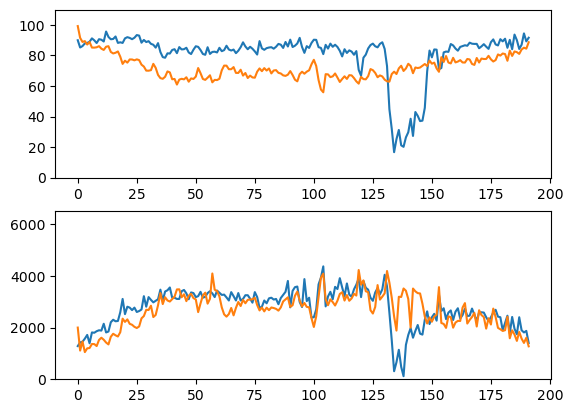

In [ ]:
fig,axs = plt.subplots(2,1)
seg = 6
axs[0].plot(V_real[:,-seg])
axs[0].plot(V_MAIN_sim_needed[::sampling_interval,-seg])
axs[0].set_ylim(0,110)
axs[1].plot(Q_real[:,-seg])
axs[1].plot(Q_MAIN_sim_needed[::sampling_interval,-seg])
axs[1].set_ylim(0,6500)
print("流量误差:",(abs(Q_real[:,-seg]-Q_MAIN_sim_needed[::sampling_interval,-seg])/Q_real[:,-seg]).mean())
print("速度误差:",(abs(V_real[:,-seg]-V_MAIN_sim_needed[::sampling_interval,-seg])/V_real[:,-seg]).mean())
q_error = []
v_error = []
for seg in range(V_real.shape[1]):
    q_error.append((abs(Q_real[:,-seg]-Q_MAIN_sim_needed[::sampling_interval,-seg])/Q_real[:,-seg]).mean())
    v_error.append((abs(V_real[:,-seg]-V_MAIN_sim_needed[::sampling_interval,-seg])/V_real[:,-seg]).mean())
print("平均流量误差:",np.mean(np.array(q_error)))
print("平均速度误差:",np.mean(np.array(v_error)))
print("最大流量误差:",np.max(np.array(q_error)))
print("最大速度误差:",np.max(np.array(v_error)))

In [ ]:
def loss_function(Q_sim, V_sim, Q_real, V_real):
    return 0.01*np.sqrt(np.mean((Q_sim - Q_real) ** 2)) + np.sqrt(np.mean((V_sim - V_real) ** 2))
# def loss_function(Q_sim, V_sim, Q_real, V_real):
#     return np.mean(abs(Q_sim - Q_real)/Q_real) + np.mean(abs(V_sim - V_real)/V_real)
# 假设你有真实的流量和速度数据
Q_real = pos_flow_array
V_real = pos_speed_array
# 定义一个优化目标函数
def objective(params):
    t_simulation = simulation_time  # 仿真步长（单位：秒）
    t_measure = measure_time    # 测量时长（单位：秒）
    # 计算采样间隔
    sampling_interval = int(t_measure / t_simulation)  # 采样间隔
    

    [tau, kappa, eta, delta, phi,
    a1, rho_crit1, rho_max1, v_free1, 
    a2, rho_crit2, rho_max2, v_free2, 
    a3, rho_crit3, rho_max3, v_free3,
    a4, rho_crit4, rho_max4, v_free4,
    a5, rho_crit5, rho_max5, v_free5,
    init_a_off1,init_rho_crit_off1,init_rho_max_off1,init_v_free_off1,
    init_a_off2,init_rho_crit_off2,init_rho_max_off2,init_v_free_off2,
    init_lane_drop_acc] = params
    
    global rho
    global v
    global w
    
    lanes = [4,4,4,4,4]
    link_lengths = [1.15,0.30,5.41,1.24,0.68]
    num_segments = [5,1,27,6,3]
    segment_lengths = [round(i,3) for i in list(np.array(link_lengths)/np.array(num_segments))]
    
    N1 = Node(name="N1")
    N2 = Node(name="N2")
    N3 = Node(name="N3")
    N4 = Node(name="N4")
    N5 = Node(name="N5")
    N6 = Node(name="N6")
    N_off1 = Node(name="N_off1")
    N_off2 = Node(name="N_off2")
    
    O1 = MainstreamOrigin[cs.SX](name="O1")
    O_GL = MeteredOnRamp[cs.SX](C, name="O_GL")
    O_JC = MeteredOnRamp[cs.SX](C, name="O_JC")
    
    D1 = Destination[cs.SX](name="D1")
    D_GL = Destination[cs.SX](name="D_GL")
    D_JC = Destination[cs.SX](name="D_JC")
    
    L1 = Link[cs.SX](num_segments[0], lanes[0], segment_lengths[0], rho_max1, rho_crit1, v_free1, a1, name="L1")
    L2 = Link[cs.SX](num_segments[1], lanes[1], segment_lengths[1], rho_max2, rho_crit2, v_free2, a2, name="L2")
    L3 = Link[cs.SX](num_segments[2], lanes[2], segment_lengths[2], rho_max3, rho_crit3, v_free3, a3, name="L3")
    L4 = Link[cs.SX](num_segments[3], lanes[3], segment_lengths[3], rho_max4, rho_crit4, v_free4, a4, name="L4")
    L5 = LinkWithAccident[cs.SX](num_segments[4], lanes[4], segment_lengths[4], rho_max5, rho_crit5, v_free5, a5, 
                            segment_with_acci=2, lane_drop=init_lane_drop_acc, accident_start_time=accident_point*sampling_interval, accident_end_time=accident_finish*sampling_interval,
                            name="L5")    
    L_off1 = Link[cs.SX](1, 2, 0.2, init_rho_max_off1, init_rho_crit_off1, init_v_free_off1, init_a_off1, name="L_off1") #1段两百米的下匝道（2车道）
    L_off2 = Link[cs.SX](1, 2, 0.2, init_rho_max_off2, init_rho_crit_off2, init_v_free_off2, init_a_off2, name="L_off2")
    
    net = (
        Network(name="A1")
        .add_path(origin=O1, path=(N1, L1, N2, L2, N3, L3, N4, L4, N5, L5, N6), destination=D1)
        .add_path(path=(N1, L1, N2,L_off1,N_off1), destination=D_GL)
        .add_path(path=(N1, L1, N2, L2, N3, L3, N4,L_off2,N_off2), destination=D_JC)
        .add_origin(O_GL, N3)
        .add_origin(O_JC, N5)
    )
    engines.use("casadi", sym_type="SX")
    net.is_valid(raises=True)
    net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta, phi=phi)
    F = metanet.engine.to_function(
        net=net,
        more_out=True,
        compact=1,
        T=T,
    )
    
    # 初始化参数
    rho = cs.DM([5 for i in range(sum([i.N for i in net.links_by_name.values()]))])
    v = cs.DM([100 for i in range(sum([i.N for i in net.links_by_name.values()]))])
    w = cs.DM([0, 0, 0])
    v_ctrl = cs.DM.inf(1, 1)  # control speed at O1
    r = cs.DM.ones(1, 1)  # ramp metering rates at O2
    
    RHO, V, Q, _, _ = [], [], [], [], []
    for index,d in enumerate(up_sampled_demands):
        rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r, up_sampled_turn_rates[index], index, d)
        RHO.append(rho)
        V.append(v)
        Q.append(q)
    global Q_sim,V_sim,Q_MAIN_sim,V_MAIN_sim,Q_MAIN_sim_needed,V_MAIN_sim_needed
    # 计算损失
    Q_sim = np.squeeze(Q) #主线+匝道
    V_sim = np.squeeze(V)
    Q_MAIN_sim = np.delete(Q_sim, off_segments, axis=1) #主线
    V_MAIN_sim = np.delete(V_sim, off_segments, axis=1) 
    Q_MAIN_sim_needed = Q_MAIN_sim[:,non_negative_cols_flow]#有实际检测器的主线
    V_MAIN_sim_needed = V_MAIN_sim[:,non_negative_cols_speed]

    # 检查是否有无效值
    if np.any(np.isnan(Q_sim)) or np.any(np.isnan(V_sim)):
        print("NaN detected in simulation results.")
        return np.inf  # 返回无穷大，表示损失无效
    print(loss_function(Q_MAIN_sim_needed[::sampling_interval,:], V_MAIN_sim_needed[::sampling_interval,:], Q_real, V_real))
    return loss_function(Q_MAIN_sim_needed[::sampling_interval,:], V_MAIN_sim_needed[::sampling_interval,:], Q_real, V_real)

# 初始参数
init_tau = 5e-3
init_kappa = 40
init_eta = 30
init_delta = 0.0122
init_phi = 0.02
init_a1, init_rho_crit1, init_rho_max1, init_v_free1 = [1.867, 30, 120, 100]
init_a2, init_rho_crit2, init_rho_max2, init_v_free2 = [1.867, 30, 120, 100]
init_a3, init_rho_crit3, init_rho_max3, init_v_free3 = [1.867, 30, 120, 100]
init_a4, init_rho_crit4, init_rho_max4, init_v_free4 = [1.867, 30, 120, 100]
init_a5, init_rho_crit5, init_rho_max5, init_v_free5 = [1.867, 30, 120, 80]
init_a_off1,init_rho_crit_off1,init_rho_max_off1,init_v_free_off1 = [1.867, 30, 120, 60]
init_a_off2,init_rho_crit_off2,init_rho_max_off2,init_v_free_off2 = [1.867, 30, 120, 60]
init_lane_drop_acc = 1.2
initial_params = [init_tau, init_kappa, init_eta, init_delta, init_phi,
                  init_a1, init_rho_crit1, init_rho_max1, init_v_free1, 
                  init_a2, init_rho_crit2, init_rho_max2, init_v_free2,
                  init_a3, init_rho_crit3, init_rho_max3, init_v_free3,
                  init_a4, init_rho_crit4, init_rho_max4, init_v_free4,
                  init_a5, init_rho_crit5, init_rho_max5, init_v_free5,
                  init_a_off1,init_rho_crit_off1,init_rho_max_off1,init_v_free_off1,
                  init_a_off2,init_rho_crit_off2,init_rho_max_off2,init_v_free_off2,
                  init_lane_drop_acc]
global_bounds = [(0,50),(0,120),(0,60),(0.0001,15),(0.0001,15)]
bounds1 = [(0.9,3),(15,45),(80,160),(60,120)]
bounds2 = [(1,4)]
bounds = []
bounds.extend(global_bounds)
for i in range(2+5):
    bounds.extend(bounds1) 
bounds.extend(bounds2)
# 初始化计数器和目标函数值历史
iteration_count = 0
history = []
# 定义回调函数
def callback(x):
    global iteration_count
    iteration_count += 1
    current_value = objective(x)
    history.append((iteration_count, current_value))
    print(f'Iteration {iteration_count}: Objective function value = {current_value}')
np.random.seed(42)
initial_params_array = [initial_params]
for i in range(len(initial_params)):
    temp_params = []
    for j in range(len(initial_params)):
        temp_value = np.random.uniform(bounds[j][0], bounds[j][1])
        temp_params.append(temp_value)
    initial_params_array.append(temp_params)
initial_params_array = np.array(initial_params_array)
# 优化参数
# result = minimize(objective, initial_params, bounds=bounds, method='Nelder-Mead',options={'xatol': 1e-8, 'fatol': 1e-8, 'maxiter': 1500,'adaptive':True},callback=callback)
result = minimize(objective, initial_params, bounds=bounds, method='Nelder-Mead',options={'xatol': 1e-8, 'fatol': 1e-8, 'maxiter': 15000,'adaptive':True,'initial_simplex':initial_params_array},callback=callback)
# 输出最优参数
optimal_params = result.x
print("Optimal parameters:", optimal_params)

24.581807226858924
29.935790400490493
33.831103339971946
31.56894181984765
23.096341637998364
22.292313558341878
23.62926802726167
NaN detected in simulation results.
NaN detected in simulation results.
28.372317525749395
30.997750596386574
23.035192640636815
27.74237655395263
36.39964195555733
23.532194435477123
22.14691706685312
22.75547807206508
22.831736528856407
28.78675569089732
NaN detected in simulation results.
24.181936222918633
23.217409123847336
22.509184138803846
24.200035717076005
28.382767510959408
28.33726679426583
39.265843205288505
25.068994166879868
23.147647260470368
43.38198377987008
22.244736416985138
24.403417287202064
25.27043580350931
25.01651260933198
25.776307897018675
27.58695143652314
22.14691706685312
Iteration 1: Objective function value = 22.14691706685312
27.557112646392024
22.14691706685312
Iteration 2: Objective function value = 22.14691706685312
24.665236148496305
22.14691706685312
Iteration 3: Objective function value = 22.14691706685312
26.46613340

/home/ljh/anaconda3/lib/python3.11/site-packages/sym_metanet/engines/casadi.py:109: RuntimeWarning: divide by zero encountered in scalar divide
  relaxation = (T / tau) * (Veq - v)
/home/ljh/anaconda3/lib/python3.11/site-packages/sym_metanet/engines/casadi.py:111: RuntimeWarning: divide by zero encountered in scalar divide
  anticipation = (eta * T / tau) * (rho_down - rho) / (L * (rho + kappa))


NaN detected in simulation results.
22.441923665635393
22.12010084155998
Iteration 115: Objective function value = 22.12010084155998
23.20228056448405
22.419700892359195
22.12010084155998
Iteration 116: Objective function value = 22.12010084155998
22.541291096483228
22.12010084155998
Iteration 117: Objective function value = 22.12010084155998
22.4170506771341
22.12010084155998
Iteration 118: Objective function value = 22.12010084155998
22.484695324866777
22.12010084155998
Iteration 119: Objective function value = 22.12010084155998
22.37839594288308
22.12010084155998
Iteration 120: Objective function value = 22.12010084155998
22.42600746787083
22.12010084155998
Iteration 121: Objective function value = 22.12010084155998
22.740998804347022
22.175275485906358
22.12010084155998
Iteration 122: Objective function value = 22.12010084155998
22.44213136430262
22.12010084155998
Iteration 123: Objective function value = 22.12010084155998
22.36783381526617
22.12010084155998
Iteration 124: Objectiv

In [ ]:
t_simulation = simulation_time  # 仿真步长（单位：秒）
t_measure = measure_time    # 测量时长（单位：秒）
# 计算采样间隔
sampling_interval = int(t_measure / t_simulation)  # 采样间隔


[tau, kappa, eta, delta, phi,
a1, rho_crit1, rho_max1, v_free1, 
a2, rho_crit2, rho_max2, v_free2, 
a3, rho_crit3, rho_max3, v_free3,
a4, rho_crit4, rho_max4, v_free4,
a5, rho_crit5, rho_max5, v_free5,
init_a_off1,init_rho_crit_off1,init_rho_max_off1,init_v_free_off1,
init_a_off2,init_rho_crit_off2,init_rho_max_off2,init_v_free_off2,
init_lane_drop_acc] = result.x

global rho
global v
global w

lanes = [4,4,4,4,4]
link_lengths = [1.15,0.30,5.41,1.24,0.68]
num_segments = [5,1,27,6,3]
segment_lengths = [round(i,3) for i in list(np.array(link_lengths)/np.array(num_segments))]

N1 = Node(name="N1")
N2 = Node(name="N2")
N3 = Node(name="N3")
N4 = Node(name="N4")
N5 = Node(name="N5")
N6 = Node(name="N6")
N_off1 = Node(name="N_off1")
N_off2 = Node(name="N_off2")

O1 = MainstreamOrigin[cs.SX](name="O1")
O_GL = MeteredOnRamp[cs.SX](C, name="O_GL")
O_JC = MeteredOnRamp[cs.SX](C, name="O_JC")

D1 = Destination[cs.SX](name="D1")
D_GL = Destination[cs.SX](name="D_GL")
D_JC = Destination[cs.SX](name="D_JC")

L1 = Link[cs.SX](num_segments[0], lanes[0], segment_lengths[0], rho_max1, rho_crit1, v_free1, a1, name="L1")
L2 = Link[cs.SX](num_segments[1], lanes[1], segment_lengths[1], rho_max2, rho_crit2, v_free2, a2, name="L2")
L3 = Link[cs.SX](num_segments[2], lanes[2], segment_lengths[2], rho_max3, rho_crit3, v_free3, a3, name="L3")
L4 = Link[cs.SX](num_segments[3], lanes[3], segment_lengths[3], rho_max4, rho_crit4, v_free4, a4, name="L4")
L5 = LinkWithAccident[cs.SX](num_segments[4], lanes[4], segment_lengths[4], rho_max5, rho_crit5, v_free5, a5, 
                        segment_with_acci=2, lane_drop=init_lane_drop_acc, accident_start_time=accident_point*sampling_interval, accident_end_time=accident_finish*sampling_interval,
                        name="L5")    
L_off1 = Link[cs.SX](1, 2, 0.2, init_rho_max_off1, init_rho_crit_off1, init_v_free_off1, init_a_off1, name="L_off1") #1段两百米的下匝道（2车道）
L_off2 = Link[cs.SX](1, 2, 0.2, init_rho_max_off2, init_rho_crit_off2, init_v_free_off2, init_a_off2, name="L_off2")

net = (
    Network(name="A1")
    .add_path(origin=O1, path=(N1, L1, N2, L2, N3, L3, N4, L4, N5, L5, N6), destination=D1)
    .add_path(path=(N1, L1, N2,L_off1,N_off1), destination=D_GL)
    .add_path(path=(N1, L1, N2, L2, N3, L3, N4,L_off2,N_off2), destination=D_JC)
    .add_origin(O_GL, N3)
    .add_origin(O_JC, N5)
)
engines.use("casadi", sym_type="SX")
net.is_valid(raises=True)
net.step(T=T, tau=tau, eta=eta, kappa=kappa, delta=delta, phi=phi)
F = metanet.engine.to_function(
    net=net,
    more_out=True,
    compact=1,
    T=T,
)

# 初始化参数
rho = cs.DM([5 for i in range(sum([i.N for i in net.links_by_name.values()]))])
v = cs.DM([100 for i in range(sum([i.N for i in net.links_by_name.values()]))])
w = cs.DM([0, 0, 0])
v_ctrl = cs.DM.inf(1, 1)  # control speed at O1
r = cs.DM.ones(1, 1)  # ramp metering rates at O2

RHO, V, Q, _, _ = [], [], [], [], []
for index,d in enumerate(up_sampled_demands):
    rho, v, w, q, q_o = F(rho, v, w, v_ctrl, r, up_sampled_turn_rates[index], index, d)
    RHO.append(rho)
    V.append(v)
    Q.append(q)
global Q_sim,V_sim,Q_MAIN_sim,V_MAIN_sim,Q_MAIN_sim_needed,V_MAIN_sim_needed
# 计算损失
Q_sim = np.squeeze(Q) #主线+匝道
V_sim = np.squeeze(V)
Q_MAIN_sim = np.delete(Q_sim, off_segments, axis=1) #主线
V_MAIN_sim = np.delete(V_sim, off_segments, axis=1) 
Q_MAIN_sim_needed = Q_MAIN_sim[:,non_negative_cols_flow]#有实际检测器的主线
V_MAIN_sim_needed = V_MAIN_sim[:,non_negative_cols_speed]

流量误差: 0.13462098689017996
速度误差: 0.242200523536744
平均流量误差: 0.14481263260509544
平均速度误差: 0.18888562448050794
最大流量误差: 0.45605723023631023
最大速度误差: 0.48689973637822476


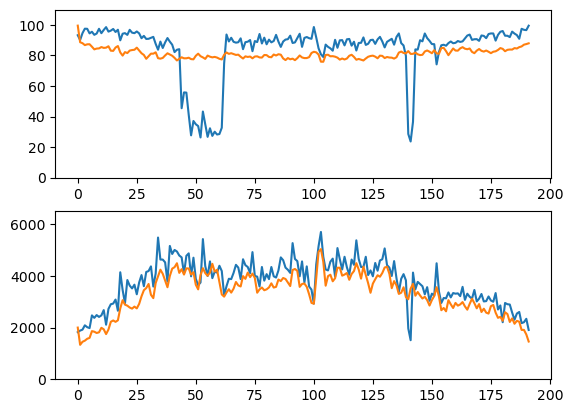

In [ ]:
fig,axs = plt.subplots(2,1)
seg = 20
axs[0].plot(V_real[:,-seg])
axs[0].plot(V_MAIN_sim_needed[::sampling_interval,-seg])
axs[0].set_ylim(0,110)
axs[1].plot(Q_real[:,-seg])
axs[1].plot(Q_MAIN_sim_needed[::sampling_interval,-seg])
axs[1].set_ylim(0,6500)
print("流量误差:",(abs(Q_real[:,-seg]-Q_MAIN_sim_needed[::sampling_interval,-seg])/Q_real[:,-seg]).mean())
print("速度误差:",(abs(V_real[:,-seg]-V_MAIN_sim_needed[::sampling_interval,-seg])/V_real[:,-seg]).mean())
q_error = []
v_error = []
for seg in range(V_real.shape[1]):
    q_error.append((abs(Q_real[:,-seg]-Q_MAIN_sim_needed[::sampling_interval,-seg])/Q_real[:,-seg]).mean())
    v_error.append((abs(V_real[:,-seg]-V_MAIN_sim_needed[::sampling_interval,-seg])/V_real[:,-seg]).mean())
print("平均流量误差:",np.mean(np.array(q_error)))
print("平均速度误差:",np.mean(np.array(v_error)))
print("最大流量误差:",np.max(np.array(q_error)))
print("最大速度误差:",np.max(np.array(v_error)))